In [1]:
import os
import random
import sys
from contextlib import contextmanager
from glob import glob
from time import time

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import NMF, PCA, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold
from category_encoders.target_encoder import TargetEncoder
from gensim.models import word2vec, KeyedVectors
from tqdm import tqdm
tqdm.pandas()

import xfeat

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

def fit_lgbm_regressor(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgbm.LGBMRegressor(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            model.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=verbose, 
                eval_metric='rmse',
                verbose=verbose)

        pred_i = model.predict(x_valid)
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))

    return oof_pred, models

def fit_lgbm_classifier(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)
    
    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        model = lgbm.LGBMClassifier(**params)
        with timer(prefix='fit fold={} '.format(i + 1)):
            model.fit(x_train, y_train, 
                eval_set=[(x_valid, y_valid)],  
                early_stopping_rounds=verbose, 
                eval_metric='logloss',
                verbose=verbose)

        pred_i = model.predict_proba(x_valid)[:,1]
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} logloss: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))

    return oof_pred, models

def create_predict_lgbm_regressor(models, feat_df):
    pred = np.array([model.predict(feat_df.values) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def create_predict_lgbm_classifier(models, feat_df):
    pred = np.array([model.predict_proba(feat_df.values)[:,1] for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def run_lgbm_regressor(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_lgbm_regressor(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_lgbm_regressor(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

def run_lgbm_classifier(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_lgbm_classifier(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_lgbm_classifier(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

def visualize_importance(models, feat_train_df):
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()

    return feature_importance_df

In [3]:
data_dir = Path('../../data')
train = pd.read_csv(data_dir.joinpath('train.csv'))
test = pd.read_csv(data_dir.joinpath('test.csv'))
sub = pd.read_csv(data_dir.joinpath('atmacup10__sample_submission.csv'))

color_df = pd.read_csv(data_dir.joinpath('color.csv'))
historical_person_df = pd.read_csv(data_dir.joinpath('historical_person.csv'))
maker_df = pd.read_csv(data_dir.joinpath('maker.csv'))
material_df = pd.read_csv(data_dir.joinpath('material.csv'))
object_collection_df = pd.read_csv(data_dir.joinpath('object_collection.csv'))
palette_df = pd.read_csv(data_dir.joinpath('palette.csv'))
principal_maker_df = pd.read_csv(data_dir.joinpath('principal_maker.csv'))
principal_maker_occupatio_df = pd.read_csv(data_dir.joinpath('principal_maker_occupation.csv'))
production_place_df = pd.read_csv(data_dir.joinpath('production_place.csv'))
technique_df = pd.read_csv(data_dir.joinpath('technique.csv'))

In [5]:
feature_list = [
    'artseriesid_count_basefeature',
    'title_tfidf',
    'title_basefeature',
    'title_label_basefeature',
    'title_count_basefeature',
    'description_tfidf',
    'description_basefeature',
    'description_label_basefeature',
    'description_count_basefeature',
    'longtitle_tfidf',
    'longtitle_basefeature',
    'longtitle_label_basefeature',
    'longtitle_count_basefeature',
    'principalmaker_label_basefeature',
    'principalmaker_count_basefeature',
    'principalorfirstmaker_label_basefeature',
    'principalorfirstmaker_count_basefeature',
    'subtitle_basefeature',
    'copyrightholder_label_basefeature',
    'copyrightholder_count_basefeature',
    'moretitle_tfidf',
    'moretitle_basefeature',
    'moretitle_label_basefeature',
    'moretitle_count_basefeature',
    'acquisitionmethod_label_basefeature',
    'acquisitionmethod_count_basefeature',
    'acquisitioncreditline_tfidf',
    'acquisitioncreditline_label_basefeature',
    'acquisitioncreditline_count_basefeature',
    'acquisitiondate_basefeature',
    'datingdate_basefeature',
    'material_basefeature',
    'object_collection_basefeature',
    'historicalperson_basefeature',
    'productionplace_basefeature',
    'technique_basefeature',
    'placeofbirth_label_basefeature',
    'placeofbirth_count_basefeature',
    'placeofdeath_label_basefeature',
    'placeofdeath_count_basefeature',
    'datebirthdeath_basefeature',
    'makername_basefeature',
    'qualification_basefeature',
    'roles_basefeature',
    'production_placesfeature',
    'principal_maker_occupatiofeature',
    'color2vec_dimension_deletionfeature',
    'bert_dimension_deletionfeature',
    'universalsentenceencoder_dimension_deletionfeature',
    'targetencoding_materialfeature',
    'targetencoding_objectcollectionfeature',
    'targetencoding_techniquefeature',
    'targetencoding_dating_periodfeature'
]

features_dir = Path('../../features/colum2131/model2')

_df = pd.crosstab(principal_maker_occupatio_df['id'], principal_maker_occupatio_df['name'])
train_features = []
test_features = []

for feature_name in feature_list:
    train_features.append(pd.read_feather(features_dir.joinpath(f'{feature_name}_train.ftr')))
    test_features.append(pd.read_feather(features_dir.joinpath(f'{feature_name}_test.ftr')))
    
train_X = pd.concat(train_features, axis=1)
test_X = pd.concat(test_features, axis=1)
train_y = np.log1p(train['likes'])

In [6]:
ensemble_dir = Path('../../ensemble/colum2131_data')

train_y = np.log1p(train['likes'])

params = {
 'reg_alpha': 1.0,
 'reg_lambda': 1.0, 
 'metric': 'rmse',
 'n_estimators': 100000,
 'objective': 'regression',
 'learning_rate': 0.01,
 'random_state': 42,
 'max_depth':6
 }

oof_lgbm = np.zeros(train_X.shape[0])
prediction_lgbm = np.zeros(test_X.shape[0])

depths = [3, 6, 10]
for depth in depths:
    params['max_depth'] = depth
    oof_lgbm, prediction_lgbm, models_lgbm, cv = run_lgbm_regressor(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=params,
        verbose=100,
        seed=12)
    print(cv)

    pd.DataFrame(oof_lgbm, train.index, columns=[f'colum2131_model2_pred{depth}_lgbm']).to_csv(ensemble_dir / f'lgbm_train_model2_depth{depth}.csv', index=False)
    pd.DataFrame(prediction_lgbm, test.index, columns=[f'colum2131_model2_pred{depth}_lgbm']).to_csv(ensemble_dir / f'lgbm_test_model2_depth{depth}.csv', index=False)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.23849
[200]	valid_0's rmse: 1.13082
[300]	valid_0's rmse: 1.09709
[400]	valid_0's rmse: 1.07903
[500]	valid_0's rmse: 1.06667
[600]	valid_0's rmse: 1.05813
[700]	valid_0's rmse: 1.05127
[800]	valid_0's rmse: 1.04557
[900]	valid_0's rmse: 1.04072


KeyboardInterrupt: 

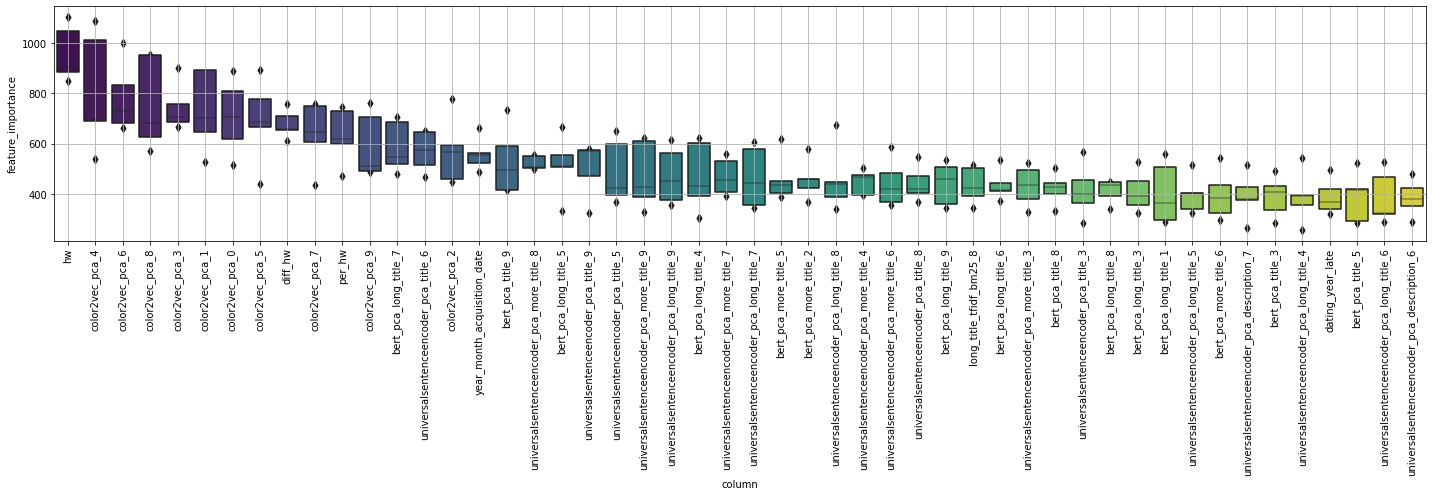

In [6]:
importance = visualize_importance(models_lgbm, train_X)

# XGbosst

In [7]:
import xgboost as xgb

# XGBoost
def fit_xgb(X, y, params: dict=None, verbose=100, seed: int=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        xgb_train = xgb.DMatrix(x_train, label=y_train)
        xgb_valid = xgb.DMatrix(x_valid, label=y_valid)
        evals = [(xgb_train,'train'),(xgb_valid,'eval')]

        model = xgb.train(
            params,
            xgb_train,
            num_boost_round=100000,
            early_stopping_rounds=verbose,
            evals=evals,
            verbose_eval=verbose)

        pred_i = model.predict(xgb.DMatrix(x_valid))
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

def create_predict_xgb(models, feat_df):
    pred = np.array([model.predict(xgb.DMatrix(feat_df)) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def run_xgb(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_xgb(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_xgb(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

In [8]:
xgb_params = {
    'objective': 'reg:squarederror',
    'eval_metric':'rmse',
    'eta':0.01,
    'lambda':1.0,
    'alpha':1.0,
    'tree_method':'gpu_hist',
    'max_depth':6
}

oof_xgb = np.zeros(train_X.shape[0])
prediction_xgb = np.zeros(test_X.shape[0])

depths = [3, 6, 10]
for depth in depths:
    xgb_params['max_depth'] = depth
    oof_xgb, prediction_xgb, models_xgb, cv = run_xgb(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=xgb_params,
        verbose=100,
        seed=12)
    print(cv)
    
    pd.DataFrame(oof_xgb, train.index, columns=[f'colum2131_model2_pred{depth}_xgb']).to_csv(ensemble_dir / f'xgb_train_model2_depth{depth}.csv', index=False)
    pd.DataFrame(prediction_xgb, test.index, columns=[f'colum2131_model2_pred{depth}_xgb']).to_csv(ensemble_dir / f'xgb_test_model2_depth{depth}.csv', index=False)

[0]	train-rmse:2.10805	eval-rmse:2.08093
[100]	train-rmse:1.33757	eval-rmse:1.30325
[200]	train-rmse:1.16394	eval-rmse:1.13985
[300]	train-rmse:1.11092	eval-rmse:1.09846
[400]	train-rmse:1.08125	eval-rmse:1.08071
[500]	train-rmse:1.05957	eval-rmse:1.06905
[600]	train-rmse:1.04159	eval-rmse:1.06107
[700]	train-rmse:1.02653	eval-rmse:1.05407
[800]	train-rmse:1.01286	eval-rmse:1.04832
[900]	train-rmse:0.99991	eval-rmse:1.04283
[1000]	train-rmse:0.98819	eval-rmse:1.03853
[1100]	train-rmse:0.97797	eval-rmse:1.03538
[1200]	train-rmse:0.96839	eval-rmse:1.03239
[1300]	train-rmse:0.95920	eval-rmse:1.02978
[1400]	train-rmse:0.95059	eval-rmse:1.02741
[1500]	train-rmse:0.94171	eval-rmse:1.02571
[1600]	train-rmse:0.93340	eval-rmse:1.02397
[1700]	train-rmse:0.92526	eval-rmse:1.02269
[1800]	train-rmse:0.91722	eval-rmse:1.02108
[1900]	train-rmse:0.90915	eval-rmse:1.01972
[2000]	train-rmse:0.90160	eval-rmse:1.01847
[2100]	train-rmse:0.89425	eval-rmse:1.01709
[2200]	train-rmse:0.88728	eval-rmse:1.01617


[3900]	train-rmse:0.79001	eval-rmse:1.00909
[4000]	train-rmse:0.78527	eval-rmse:1.00874
[4100]	train-rmse:0.78065	eval-rmse:1.00842
[4200]	train-rmse:0.77589	eval-rmse:1.00807
[4300]	train-rmse:0.77137	eval-rmse:1.00773
[4400]	train-rmse:0.76680	eval-rmse:1.00779
[4418]	train-rmse:0.76597	eval-rmse:1.00774
Fold 2 RMSE: 1.0077
[0]	train-rmse:2.09658	eval-rmse:2.12720
[100]	train-rmse:1.32688	eval-rmse:1.36402
[200]	train-rmse:1.15353	eval-rmse:1.19742
[300]	train-rmse:1.10122	eval-rmse:1.15412
[400]	train-rmse:1.07250	eval-rmse:1.13250
[500]	train-rmse:1.05228	eval-rmse:1.11900
[600]	train-rmse:1.03567	eval-rmse:1.10951
[700]	train-rmse:1.02095	eval-rmse:1.10246
[800]	train-rmse:1.00858	eval-rmse:1.09779
[900]	train-rmse:0.99713	eval-rmse:1.09336
[1000]	train-rmse:0.98628	eval-rmse:1.08879
[1100]	train-rmse:0.97598	eval-rmse:1.08469
[1200]	train-rmse:0.96639	eval-rmse:1.08180
[1300]	train-rmse:0.95698	eval-rmse:1.07888
[1400]	train-rmse:0.94828	eval-rmse:1.07670
[1500]	train-rmse:0.9400

[6100]	train-rmse:0.69112	eval-rmse:1.02901
[6200]	train-rmse:0.68722	eval-rmse:1.02896
[6263]	train-rmse:0.68491	eval-rmse:1.02892
Fold 4 RMSE: 1.0289
FINISHED \ whole score: 1.0157
1.015724981445364
[0]	train-rmse:2.10708	eval-rmse:2.08042
[100]	train-rmse:1.23122	eval-rmse:1.25459
[200]	train-rmse:0.97794	eval-rmse:1.06886
[300]	train-rmse:0.87637	eval-rmse:1.02359
[400]	train-rmse:0.81124	eval-rmse:1.00762
[500]	train-rmse:0.76560	eval-rmse:0.99975
[600]	train-rmse:0.73026	eval-rmse:0.99415
[700]	train-rmse:0.70053	eval-rmse:0.99065
[800]	train-rmse:0.67625	eval-rmse:0.98839
[900]	train-rmse:0.65070	eval-rmse:0.98673
[1000]	train-rmse:0.62746	eval-rmse:0.98521
[1100]	train-rmse:0.60454	eval-rmse:0.98455
[1200]	train-rmse:0.58007	eval-rmse:0.98363
[1300]	train-rmse:0.55932	eval-rmse:0.98244
[1400]	train-rmse:0.53759	eval-rmse:0.98155
[1500]	train-rmse:0.51870	eval-rmse:0.98116
[1600]	train-rmse:0.50034	eval-rmse:0.98081
[1700]	train-rmse:0.48280	eval-rmse:0.98031
[1800]	train-rmse:0

[300]	train-rmse:0.49894	eval-rmse:1.02112
[400]	train-rmse:0.39958	eval-rmse:1.01497
[500]	train-rmse:0.33158	eval-rmse:1.01127
[600]	train-rmse:0.27886	eval-rmse:1.00830
[700]	train-rmse:0.23021	eval-rmse:1.00656
[800]	train-rmse:0.19594	eval-rmse:1.00585
[900]	train-rmse:0.16799	eval-rmse:1.00582
[1000]	train-rmse:0.14380	eval-rmse:1.00512
[1100]	train-rmse:0.12395	eval-rmse:1.00501
[1200]	train-rmse:0.10711	eval-rmse:1.00484
[1300]	train-rmse:0.09469	eval-rmse:1.00451
[1400]	train-rmse:0.08353	eval-rmse:1.00435
[1500]	train-rmse:0.07388	eval-rmse:1.00415
[1600]	train-rmse:0.06629	eval-rmse:1.00417
[1620]	train-rmse:0.06492	eval-rmse:1.00415
Fold 2 RMSE: 1.0042
[0]	train-rmse:2.09421	eval-rmse:2.12653
[100]	train-rmse:1.05023	eval-rmse:1.29551
[200]	train-rmse:0.66348	eval-rmse:1.09224
[300]	train-rmse:0.49451	eval-rmse:1.04203
[400]	train-rmse:0.39809	eval-rmse:1.02668
[500]	train-rmse:0.33391	eval-rmse:1.01974
[600]	train-rmse:0.27463	eval-rmse:1.01532
[700]	train-rmse:0.22703	eva

# CatBoost

In [9]:
# Catboost
from catboost import CatBoost, Pool

def fit_cat(X, y, params: dict=None, verbose=100, seed=42):
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    bins = [1 if i > 0 else 0 for i in train_y.tolist()]
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    for i, (idx_train, idx_valid) in enumerate(kf.split(X, bins)): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

        train_pool = Pool(
            x_train,
            label=y_train,
            cat_features=categorycal_list)
        
        valid_pool = Pool(
            x_valid,
            label=y_valid,
            cat_features=categorycal_list)
        
        model = CatBoost(params)
        model.fit(
            train_pool,
            early_stopping_rounds=verbose,
            plot=False,
            use_best_model=True,
            eval_set=[valid_pool],
            verbose=verbose)

        pred_i = model.predict(x_valid)
        oof_pred[x_valid.index] = pred_i
        models.append(model)
        print(f'Fold {i} RMSE: {np.sqrt(mean_squared_error(y_valid, pred_i)):.4f}')

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models

def create_predict_cat(models, feat_df):
    pred = np.array([model.predict(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

def run_cat(train_X: pd.DataFrame, train_y: pd.Series, test: pd.DataFrame, params: dict, verbose: int=50, seed: int=42):
    oof_pred, models = fit_cat(train_X, train_y, params=params, verbose=verbose, seed=seed)
    prediction = create_predict_cat(models, test)
    cv = np.sqrt(mean_squared_error(train_y, oof_pred))
    return oof_pred, prediction, models, cv

In [10]:
categorycal_list = []
for i, col in enumerate(train_X.columns):
    if 'label' in col:
        categorycal_list.append(i)
        train_X[col] = train_X[col].astype(object)
        test_X[col] = test_X[col].astype(object)

In [11]:
cat_params = {
    'loss_function': 'RMSE',
    'num_boost_round': 100000,
    'learning_rate': 0.03,
    'random_state': 42,
    'task_type': 'CPU',
    'depth':6
}


oof_cat = np.zeros(train_X.shape[0])
prediction_cat = np.zeros(test_X.shape[0])

depths = [3, 6, 10]
for depth in depths:
    cat_params['depth'] = depth
    oof_cat, prediction_cat, models_cat, cv = run_cat(
        train_X=train_X,
        train_y=train_y,
        test=test_X,
        params=cat_params,
        verbose=100,
        seed=12)
    print(cv)

    pd.DataFrame(oof_cat, train.index, columns=[f'colum2131_model2_pred{depth}_cat']).to_csv(ensemble_dir / f'cat_train_model2_depth{depth}.csv', index=False)
    pd.DataFrame(prediction_cat, test.index, columns=[f'colum2131_model2_pred{depth}_cat']).to_csv(ensemble_dir / f'cat_test_model2_depth{depth}.csv', index=False)

0:	learn: 1.7545082	test: 1.7197475	best: 1.7197475 (0)	total: 77.5ms	remaining: 2h 9m 9s
100:	learn: 1.1582192	test: 1.1085752	best: 1.1085752 (100)	total: 2.48s	remaining: 40m 55s
200:	learn: 1.1131951	test: 1.0741172	best: 1.0741172 (200)	total: 4.76s	remaining: 39m 25s
300:	learn: 1.0866874	test: 1.0581446	best: 1.0581446 (300)	total: 7.17s	remaining: 39m 34s
400:	learn: 1.0606648	test: 1.0455933	best: 1.0455933 (400)	total: 9.73s	remaining: 40m 16s
500:	learn: 1.0390049	test: 1.0363125	best: 1.0363125 (500)	total: 12s	remaining: 39m 51s
600:	learn: 1.0214755	test: 1.0303483	best: 1.0302700 (599)	total: 14.4s	remaining: 39m 38s
700:	learn: 1.0063222	test: 1.0262519	best: 1.0262170 (698)	total: 16.9s	remaining: 39m 48s
800:	learn: 0.9922260	test: 1.0230870	best: 1.0230870 (800)	total: 19.2s	remaining: 39m 38s
900:	learn: 0.9796707	test: 1.0193112	best: 1.0193020 (899)	total: 21.6s	remaining: 39m 32s
1000:	learn: 0.9673549	test: 1.0171423	best: 1.0171219 (998)	total: 24s	remaining: 3

1000:	learn: 0.9662917	test: 1.0273164	best: 1.0273151 (999)	total: 22.8s	remaining: 37m 36s
1100:	learn: 0.9554976	test: 1.0249142	best: 1.0249025 (1099)	total: 24.9s	remaining: 37m 20s
1200:	learn: 0.9448919	test: 1.0233116	best: 1.0232401 (1198)	total: 27.2s	remaining: 37m 16s
1300:	learn: 0.9352742	test: 1.0211232	best: 1.0211232 (1300)	total: 29.3s	remaining: 37m 6s
1400:	learn: 0.9254673	test: 1.0198214	best: 1.0197923 (1399)	total: 31.9s	remaining: 37m 21s
1500:	learn: 0.9166055	test: 1.0185156	best: 1.0184993 (1498)	total: 34s	remaining: 37m 11s
1600:	learn: 0.9081146	test: 1.0171645	best: 1.0171645 (1600)	total: 36.3s	remaining: 37m 8s
1700:	learn: 0.9000239	test: 1.0154160	best: 1.0154160 (1700)	total: 38.4s	remaining: 37m
1800:	learn: 0.8915414	test: 1.0144373	best: 1.0143648 (1780)	total: 40.6s	remaining: 36m 56s
1900:	learn: 0.8835830	test: 1.0128262	best: 1.0128262 (1900)	total: 42.8s	remaining: 36m 48s
2000:	learn: 0.8761787	test: 1.0122336	best: 1.0122126 (1998)	total: 

1800:	learn: 0.8858060	test: 1.0319238	best: 1.0319238 (1800)	total: 37.5s	remaining: 34m 6s
1900:	learn: 0.8776208	test: 1.0305633	best: 1.0305633 (1900)	total: 39.7s	remaining: 34m 9s
2000:	learn: 0.8692935	test: 1.0288194	best: 1.0287620 (1999)	total: 41.7s	remaining: 34m 2s
2100:	learn: 0.8620981	test: 1.0277189	best: 1.0277189 (2100)	total: 43.7s	remaining: 33m 56s
2200:	learn: 0.8548218	test: 1.0267977	best: 1.0267532 (2199)	total: 45.7s	remaining: 33m 48s
2300:	learn: 0.8473107	test: 1.0255502	best: 1.0254902 (2296)	total: 47.7s	remaining: 33m 43s
2400:	learn: 0.8402641	test: 1.0241206	best: 1.0241206 (2400)	total: 49.8s	remaining: 33m 42s
2500:	learn: 0.8330778	test: 1.0228260	best: 1.0227513 (2497)	total: 51.9s	remaining: 33m 41s
2600:	learn: 0.8255765	test: 1.0222810	best: 1.0222506 (2573)	total: 53.9s	remaining: 33m 38s
2700:	learn: 0.8189389	test: 1.0217276	best: 1.0216893 (2689)	total: 55.9s	remaining: 33m 33s
2800:	learn: 0.8124214	test: 1.0210368	best: 1.0210251 (2798)	t

1000:	learn: 0.7878778	test: 0.9956668	best: 0.9956668 (1000)	total: 50.8s	remaining: 1h 23m 40s
1100:	learn: 0.7657246	test: 0.9927539	best: 0.9927539 (1100)	total: 55.9s	remaining: 1h 23m 44s
1200:	learn: 0.7448588	test: 0.9914340	best: 0.9914340 (1200)	total: 1m	remaining: 1h 23m 37s
1300:	learn: 0.7252171	test: 0.9894540	best: 0.9893474 (1298)	total: 1m 6s	remaining: 1h 23m 30s
1400:	learn: 0.7053066	test: 0.9874982	best: 0.9874424 (1391)	total: 1m 11s	remaining: 1h 23m 19s
1500:	learn: 0.6870379	test: 0.9861216	best: 0.9860842 (1498)	total: 1m 16s	remaining: 1h 23m 8s
1600:	learn: 0.6705749	test: 0.9856776	best: 0.9856776 (1600)	total: 1m 21s	remaining: 1h 22m 59s
1700:	learn: 0.6537980	test: 0.9847610	best: 0.9847372 (1689)	total: 1m 26s	remaining: 1h 22m 53s
1800:	learn: 0.6378653	test: 0.9838107	best: 0.9837055 (1792)	total: 1m 31s	remaining: 1h 22m 45s
1900:	learn: 0.6224687	test: 0.9833705	best: 0.9831777 (1885)	total: 1m 36s	remaining: 1h 22m 35s
2000:	learn: 0.6078870	test:

1800:	learn: 0.2226639	test: 0.9685145	best: 0.9683865 (1787)	total: 16m 20s	remaining: 14h 50m 40s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9683865181
bestIteration = 1787

Shrink model to first 1788 iterations.
Fold 0 RMSE: 0.9684
0:	learn: 1.7443145	test: 1.7573632	best: 1.7573632 (0)	total: 601ms	remaining: 16h 40m 55s
100:	learn: 0.9860103	test: 1.1199812	best: 1.1199812 (100)	total: 1m	remaining: 16h 34m 3s
200:	learn: 0.8447136	test: 1.0723837	best: 1.0723837 (200)	total: 2m	remaining: 16h 37m 13s
300:	learn: 0.7521121	test: 1.0510930	best: 1.0510930 (300)	total: 3m	remaining: 16h 36m 53s
400:	learn: 0.6755764	test: 1.0390239	best: 1.0390239 (400)	total: 4m	remaining: 16h 34m 15s
500:	learn: 0.6227179	test: 1.0318643	best: 1.0318204 (499)	total: 4m 59s	remaining: 16h 31m 17s
600:	learn: 0.5660483	test: 1.0268025	best: 1.0268025 (600)	total: 5m 59s	remaining: 16h 29m 38s
700:	learn: 0.5163596	test: 1.0229524	best: 1.0229524 (700)	total: 6m 58s	remainin

1400:	learn: 0.2808399	test: 1.0152957	best: 1.0152415 (1389)	total: 15m 7s	remaining: 17h 45m 1s
1500:	learn: 0.2589509	test: 1.0147570	best: 1.0147067 (1492)	total: 16m 9s	remaining: 17h 40m 5s
1600:	learn: 0.2398583	test: 1.0145898	best: 1.0144353 (1554)	total: 17m 10s	remaining: 17h 35m 20s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.014435291
bestIteration = 1554

Shrink model to first 1555 iterations.
Fold 4 RMSE: 1.0144
FINISHED \ whole score: 0.9973
0.9972923023235911
